# Heatmap
Heatmap of terms over time for Euroleaks and Communiques.

In [1]:
import re
import time
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
import spacy

## stopwords and collocations

In [2]:
# stopwords
with open('../data/euroleaks/stopwords.json', 'r') as f:
    stopwords = json.load(f)
    
# collocations
def apply_trigram_colloc(s, set_colloc):
    res = s.lower()
    for b1,b2,b3 in set_colloc:
        res = res.replace(f'{b1} {b2} {b3}', f'{b1}_{b2}_{b3}')
    return res

def apply_bigram_colloc(s, set_colloc):
    res = s.lower()
    for b1,b2 in set_colloc:
        res = res.replace(f'{b1} {b2}', f'{b1}_{b2}')
    return res

with open('../data/collocations/trigrams.json', 'r') as f:
    trigram_colloc = json.load(f)

with open('../data/collocations/bigrams.json', 'r') as f:
    bigram_colloc = json.load(f)

In [3]:
stopwords.keys()

dict_keys(['names', 'disfluency', 'courtesy'])

In [4]:
nlp = spacy.load("en_core_web_sm", exclude=["ner"])

## helper functions

In [5]:
def filter_token(token):
    return token.pos_ in {'ADJ', 'ADV', 'NOUN', 'PROPN', 'VERB'}\
        and not token.is_stop\
        and not token.lower_ in stopwords['names']\
        and not token.lower_ in stopwords['disfluency']\
        and not token.lemma_.lower() in stopwords['courtesy']\
        and len(token.lemma_) > 1

In [6]:
def find_most_prominent_k_words(k, X, vectorizer):
    
    print(f'matrix shape: {X.shape}\n')
    
    tfidf = X.sum(axis =0).A1
    sort_ix = np.argsort(tfidf)[::-1]
    most_prominent_words = np.array(vectorizer.get_feature_names())[sort_ix][:k]
    
    max_length = pd.Series(most_prominent_words).apply(lambda s: len(s)).max()
    
    for word, score in zip(most_prominent_words, tfidf[sort_ix][:k]):
        print(f'{word}{" "*(max_length-len(word))}\t|\t{round(score,3)}')
        
    return most_prominent_words

def find_most_prominent_words_cutoff(cut_off, X, vectorizer, verbose=False):
    
    print(f'matrix shape: {X.shape}\n')
    
    tfidf = X.sum(axis =0).A1
    sort_ix = np.argsort(tfidf)[::-1]
    mask = tfidf[sort_ix] > cut_off
    most_prominent_words = np.array(vectorizer.get_feature_names())[sort_ix][mask]
    
    print(f'number of prominent words: {len(most_prominent_words)}\n')
    print(f'ratio of prominent words (relative to vocabulary size): {round(float(len(most_prominent_words)) / len(vectorizer.get_feature_names()) * 100,2)} %\n')
    
    if verbose:
        max_length = pd.Series(most_prominent_words).apply(lambda s: len(s)).max()
        for word, score in zip(most_prominent_words, tfidf[sort_ix][mask]):
            print(f'{word}{" "*(max_length-len(word))}\t|\t{round(score,3)}')
        
    return most_prominent_words

## Communiques

In [7]:
communiques = pd.read_csv('../data/communiques/cleaned.csv')

# group by date
communiques_groupby_date = communiques.drop(columns=['title']).groupby('date').apply(lambda s: ' '.join(s.story))

# preprocess
communique_documents = [
    ' '.join([token.lemma_ .lower() for sentence in nlp(doc).sents for token in sentence
            if filter_token(token)
    ])
    for doc in communiques_groupby_date.values
]

# leave out empty documents
communique_documents = [d for d in communique_documents if len(d)>1]

# apply collocations
communique_documents = [
    apply_bigram_colloc(apply_trigram_colloc(doc, trigram_colloc), bigram_colloc)
    for doc in communique_documents]

# get labels
communique_dates = communiques_groupby_date.index.to_series().apply(lambda s: pd.to_datetime(s).strftime('%d/%m'))

# tfidf
communique_vectorizer = TfidfVectorizer(analyzer='word',
                                   min_df=1, # word has to be in at least two documents
                                   max_df=0.95, # word has to be in less the 95% of documents
                                   smooth_idf=True, # Smooth idf weights by adding one to document frequencies, as if an extra document was seen containing every term in the collection exactly once. Prevents zero divisions.
                                   sublinear_tf=False) # replace tf with 1 + log(tf).

communique_X = communique_vectorizer.fit_transform(communique_documents)

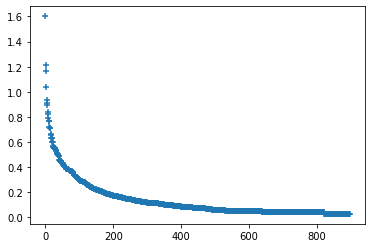

In [8]:
communique_tfidf = communique_X.sum(axis =0).A1

plt.scatter(range(len(communique_tfidf)), np.sort(communique_tfidf)[::-1], marker='+')

In [9]:
communique_cutoff = 0.2

communique_most_prominent_words = find_most_prominent_words_cutoff(communique_cutoff, communique_X, communique_vectorizer)

matrix shape: (13, 898)

number of prominent words: 170

ratio of prominent words (relative to vocabulary size): 18.93 %



In [35]:
_ = find_most_prominent_k_words(30, communique_X, communique_vectorizer)

matrix shape: (13, 898)

institution    	|	1.602
proposal       	|	1.216
greek_authority	|	1.167
program        	|	1.04
talk           	|	0.931
measure        	|	0.912
greece         	|	0.895
agreement      	|	0.835
work           	|	0.826
current        	|	0.788
inform         	|	0.768
greek          	|	0.765
situation      	|	0.718
agree          	|	0.714
reform         	|	0.713
discuss        	|	0.662
today          	|	0.657
state_play     	|	0.634
extension      	|	0.629
arrangement    	|	0.629
discussion     	|	0.602
meeting        	|	0.599
view           	|	0.566
start          	|	0.564
commitment     	|	0.56
euro_area      	|	0.554
referendum     	|	0.553
financial      	|	0.552
progress       	|	0.549
list           	|	0.543


In [11]:
print(f'Terms that are present in more than {int(len(communique_documents) * 0.95)} documents are disregarded.')

Terms that are present in more than 12 documents are disregarded.


In [12]:
print(f'Communiques vocabulary size: {len(communique_vectorizer.get_feature_names())}')
print(f'Number of documents: {len(communique_documents)}')

Communiques vocabulary size: 898
Number of documents: 13


## Euroleaks

In [13]:
leaks = pd.read_csv('../data/euroleaks/squeezed.csv')

# group by date
leaks_groupby_date = leaks.drop(columns=['speaker']).groupby('date').apply(lambda s: ' '.join(s.speech))

# preprocess
leaks_documents = [
    ' '.join([token.lemma_.lower() for sentence in nlp(doc).sents for token in sentence
            if filter_token(token)
    ])
    for doc in leaks_groupby_date.values 
]

# leave out empty documents
leaks_documents = [d for d in leaks_documents if len(d)>1]

# apply collocations
leaks_documents = [
    apply_bigram_colloc(apply_trigram_colloc(doc, trigram_colloc), bigram_colloc)
    for doc in leaks_documents]

# get labels
leaks_dates = leaks_groupby_date.index.to_series().apply(lambda s: pd.to_datetime(s).strftime('%d/%m'))

# tfidf
leaks_vectorizer = TfidfVectorizer(analyzer='word',
                                   min_df=1, # word has to be in at least two documents
                                   max_df=0.95, # word has to be in less the 95% of documents
                                   smooth_idf=True, # Smooth idf weights by adding one to document frequencies, as if an extra document was seen containing every term in the collection exactly once. Prevents zero divisions.
                                   sublinear_tf=False) # replace tf with 1 + log(tf).

leaks_X = leaks_vectorizer.fit_transform(leaks_documents)

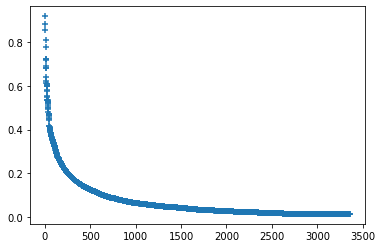

In [14]:
leaks_tfidf = leaks_X.sum(axis =0).A1

plt.scatter(range(len(leaks_tfidf))[5:], np.sort(leaks_tfidf)[::-1][5:], marker='+')

In [15]:
leaks_cutoff = 0.15

leaks_most_prominent_words = find_most_prominent_words_cutoff(leaks_cutoff, leaks_X, leaks_vectorizer)

matrix shape: (12, 3357)

number of prominent words: 398

ratio of prominent words (relative to vocabulary size): 11.86 %



In [36]:
_ = find_most_prominent_k_words(30, leaks_X, leaks_vectorizer)

matrix shape: (12, 3357)

agreement   	|	1.902
program     	|	1.367
process     	|	1.165
reform      	|	1.123
referendum  	|	1.008
letter      	|	0.918
eurogroup   	|	0.882
list        	|	0.854
new         	|	0.811
like        	|	0.779
change      	|	0.723
liquidity   	|	0.721
pension     	|	0.716
month       	|	0.689
week        	|	0.684
day         	|	0.681
document    	|	0.642
progress    	|	0.622
fiscal      	|	0.614
tomorrow    	|	0.607
review      	|	0.606
take        	|	0.601
political   	|	0.6
prior_action	|	0.6
parliament  	|	0.58
policy      	|	0.577
statement   	|	0.554
table       	|	0.55
believe     	|	0.536
problem     	|	0.534


In [17]:
print(f'Terms that are presint in more than {int(len(leaks_documents) * 0.95)} documents are disregarded.')

Terms that are presint in more than 11 documents are disregarded.


In [18]:
print(f'Communiques vocabulary size: {len(leaks_vectorizer.get_feature_names())}')
print(f'Number of documents: {len(leaks_documents)}')

Communiques vocabulary size: 3357
Number of documents: 12


## make figure for cutoffs

Text(2349, 0.18, 'cut off = 0.15')

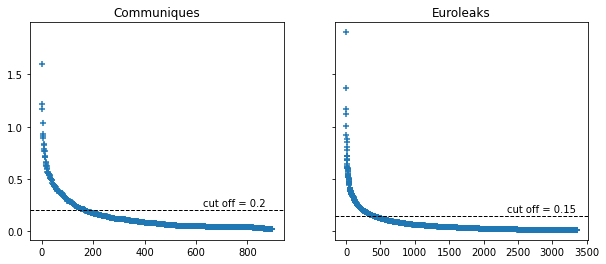

In [39]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10,4))

axes[0].scatter(range(len(communique_tfidf)), np.sort(communique_tfidf)[::-1], marker='+')
axes[0].axhline(communique_cutoff, 0,len(communique_tfidf), color='black', linewidth=1, linestyle='--')
axes[0].set_title('Communiques')
axes[0].set_yticks([0, .5, 1, 1.5])
axes[0].text(int(len(communique_tfidf)*.7), communique_cutoff*1.2, f'cut off = {communique_cutoff}')

axes[1].scatter(range(len(leaks_tfidf)), np.sort(leaks_tfidf)[::-1], marker='+')
axes[1].axhline(leaks_cutoff, 0,len(leaks_tfidf), color='black', linewidth=1, linestyle='--')
axes[1].set_title('Euroleaks')
axes[1].text(int(len(leaks_tfidf)*.7), leaks_cutoff*1.2, f'cut off = {leaks_cutoff}')

## find differences

In [20]:
# prominent words in communiques which are not prominent in euroleaks
comm_but_not_leaks = []

for word in communique_most_prominent_words:
    if word not in leaks_most_prominent_words:
        comm_but_not_leaks.append(word)
        
print(f'Number of words: {len(comm_but_not_leaks)}\n')
for word in comm_but_not_leaks:
    print(word)

Number of words: 69

institution
proposal
greek_authority
talk
measure
greece
work
inform
greek
situation
agree
discuss
today
state_play
discussion
meeting
view
start
euro_area
financial
give
monday
time
come
good
greek_government
need
ground
issue
decision
recovery
look
pm
stock
government
basis
ireland
regular
thursday
efsf
number
end
go
portugal
step
note
cyprus
inevitable
initiative
heads
regrettable
tuesday
short
july
course
question
concerned
structural_reform
member_states
wide
main
national_procedure
meantime
press_conference
door
surveillance
intensive
spain
lot


In [21]:
# prominent words in communiques which are not prominent in euroleaks

leaks_but_not_comms = []

for word in leaks_most_prominent_words:
    if word not in communique_most_prominent_words:
        leaks_but_not_comms.append(word)
        
print(f'Number of words: {len(leaks_but_not_comms)}\n')
for word in leaks_but_not_comms:
    print(word)

Number of words: 297

letter
eurogroup
change
liquidity
pension
document
tomorrow
prior_action
parliament
believe
problem
public
greek_people
propose
debt
tax
second_letter
country
area
people
deal
athens
bank
line
minister
mou
technical
aide_memoire
significant
set
market
meet
detail
rate
target
euro
concern
package
answer
actually
low
credibility
authority
system
communication
move
esm
send
certainly
increase
brussels_group
find
sure
help
able
interest_rate
prime_minister
reason
high
complete
general
tell
fact
mandate
previous
ahead
push
ecb
large
great
growth_friendly
hope
respect
medium
intention
speak
plan
bill
matter
friday
exist
turn
sustainable
vote
paper
remark
gdp
additional
direction
moment
convergence
vat
amendment
require
create
early
morning
trust
run
absolutely
difference
action
credible
privatization
close
hour
euro_working_group
have
scenario
feel
report
available
get
happen
bit
expect
example
necessary
extremely
assess
perspective
implement
hand
sla
principle
money
ov

In [22]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

assert len(intersection(comm_but_not_leaks, leaks_but_not_comms)) == 0

### words of interest (collect manually)

In [23]:
# manually collecter words of interest, which highlight differences

highlight_differences = set([
    
    # comms but not leaks
    #'institution', # prominent in both (vectorizere filters it out for leaks because present in every document)
    #'ireland',
    #'portugal',
    #'cyprus',
    'structural_reform',
    #'national_procedure',
    #'spain',
    'recovery',

    # leaks but not comms
    'letter',
    'liquidity',
    'pension',
    'parliament',
    'debt',
    'tax',
    'second_letter',
    'bank',
    'mou',
    'aide_memoire',
    'market',
    #'esm', # European stability mechanism
    'brussels_group',
    #'interest_rate',
    #'prime_minister',
    'mandate',
    #'ecb', # European Central Bank
    'bill',
    'gdp',
    'vat', # value-added tax
    'privatization',
    'sla', # staff level agreement
    #'low_interest_rate',
    'law',
    'primary_surplus',
    'labor_market',
    'recession',
    'budget',
    
    # interesting collocations
    'minimum_wage',
    'labor_market',
    'collective_bargaining',
    'structural_reform',
    'second_letter',
    #'non_performing_loan',
    #'capital_control',
    'primary_surplus',
    'aide_memoire',
    'brussels_group',
    #'quantitative_easing',
    'smp_bond',
    
    # prominent when tfidf trained on joint communiques + euroleaks
    'reform',
    'extension',
    'referendum',
    'list',
    'agreement',
    
    # domain knowledge (Varoufakis claims they refused to talk debt restructuring)
    'restructuring'
      
])

# convert to list so that ordering is fixed
highlight_differences = list(highlight_differences)
# sort the list
highlight_differences.sort()

In [24]:
print(len(highlight_differences))

34


### words that are completely absent from one vocabulary

In [25]:
from pprint import pprint

In [26]:
# words in communiques which are not prominent and are absent from euroleaks

my_list = [word for word in communique_vectorizer.get_feature_names() if word not in communique_most_prominent_words and word not in leaks_vectorizer.get_feature_names()]

print(len(my_list),'\n')
#pprint(my_list)

132 



In [27]:
# words in euroleaks which are not prominent and are absent from communiques

my_list = [word for word in leaks_vectorizer.get_feature_names() if word not in leaks_most_prominent_words and word not in communique_vectorizer.get_feature_names()]

print(len(my_list),'\n')
#pprint(my_list)

2510 



### inspect collocations

In [28]:
for word in set(communique_vectorizer.get_feature_names() + leaks_vectorizer.get_feature_names()):
    if '_' in word:
        print(word)

greek_authority
central_bank
debt_sustainability_analysis
collective_bargaining
state_play
brussels_group
greek_governmental
central_banking
non_performing_loan
mission_chief
press_conference
et_cetera
duration_mffa
labor_market
international_monetary_fund
track_record
central_banks
member_state
real_estate
low_interest_rate
smp_bond
structural_reform
growth_friendly
interest_rate
prior_actions
uncharted_territory
safety_net
prior_action
sign_dotted_line
debt_sustainability
prime_minister
banking_union
maximum_flexibility
govern_council
euro_area
national_procedure
greek_government
monetary_union
master_financial_assistance
product_market
quantitative_easing
aide_memoire
arm_length
technical_team
member_states
primary_surplus
20th_february
financial_stability
common_ground
euro_working_group
united_states
central_banker
capital_control
second_letter
european_semester
successful_conclusion_review
minimum_wage
greek_people
anti_corruption
half_percent


## most prominent words (trained together)

In [40]:
documents = leaks_documents + communique_documents
dates = pd.concat((leaks_dates, communique_dates)).values

tfidf_vectorizer = TfidfVectorizer(analyzer='word',
                                   min_df=1, # word has to be in at least two documents
                                   max_df=0.99, # word has to be in less the 95% of documents
                                   smooth_idf=True, # Smooth idf weights by adding one to document frequencies, as if an extra document was seen containing every term in the collection exactly once. Prevents zero divisions.
                                   sublinear_tf=False) # replace tf with 1 + log(tf).

X = tfidf_vectorizer.fit_transform(documents)

leaks_most_prominent_words = find_most_prominent_k_words(30, X, tfidf_vectorizer)

matrix shape: (25, 3530)

institution    	|	3.468
eurogroup      	|	2.508
proposal       	|	2.305
agreement      	|	2.208
program        	|	2.085
need           	|	2.035
know           	|	1.904
work           	|	1.749
greece         	|	1.708
greek_authority	|	1.692
agree          	|	1.601
measure        	|	1.57
question       	|	1.569
go             	|	1.565
reform         	|	1.557
greek          	|	1.491
come           	|	1.426
time           	|	1.368
discussion     	|	1.363
referendum     	|	1.359
government     	|	1.356
talk           	|	1.337
process        	|	1.334
situation      	|	1.304
meeting        	|	1.28
discuss        	|	1.222
list           	|	1.188
today          	|	1.167
new            	|	1.11
issue          	|	1.09


In [30]:
# tfidf scores of words of interest, when tfidf is trained on joint text

from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(max_df=0.95)
counts = count_vectorizer.fit_transform(leaks_documents + communique_documents)

tfidf = X.sum(axis =0).A1

print(f'word{" "*(20-4)}\t|\ttfidf\t|\tcount\t| prominent in\t| prominent in')
print(f'{" "*20}\t|\t\t|\t\t| communiques\t| euroleaks')
print('-'*100)
for word in highlight_differences:
    index = tfidf_vectorizer.vocabulary_[word]
    print(f'{word}{" "*(20-len(word))}\t|\t{round(tfidf[index],3)}\t|\t{counts.sum(axis=0).A1[count_vectorizer.vocabulary_[word]]}\t|\t{word in communique_most_prominent_words}\t|\t{word in leaks_most_prominent_words}')

word                	|	tfidf	|	count	| prominent in	| prominent in
                    	|		|		| communiques	| euroleaks
----------------------------------------------------------------------------------------------------
agreement           	|	2.208	|	299	|	True	|	True
aide_memoire        	|	0.338	|	31	|	False	|	False
bank                	|	0.506	|	63	|	False	|	False
bill                	|	0.239	|	13	|	False	|	False
brussels_group      	|	0.312	|	30	|	False	|	False
budget              	|	0.141	|	15	|	False	|	False
collective_bargaining	|	0.118	|	12	|	False	|	False
debt                	|	0.553	|	72	|	False	|	False
extension           	|	0.872	|	65	|	True	|	True
gdp                 	|	0.258	|	32	|	False	|	False
labor_market        	|	0.171	|	21	|	False	|	False
law                 	|	0.181	|	14	|	False	|	False
letter              	|	0.967	|	70	|	False	|	True
liquidity           	|	0.675	|	69	|	False	|	True
list                	|	1.188	|	126	|	True	|	True
mandate             	|	0.333	|	37	

## Figure
Grid: https://stackoverflow.com/questions/38973868/adjusting-gridlines-and-ticks-in-matplotlib-imshow

In [31]:
leaks_matshow = np.zeros((len(highlight_differences), len(leaks_dates)))

for i,word in enumerate(highlight_differences):
    if word in leaks_vectorizer.get_feature_names():
        leaks_matshow[i] = leaks_X.toarray()[:,leaks_vectorizer.get_feature_names().index(word)]
        
comm_matshow = np.zeros((len(highlight_differences), len(communique_dates)))

for i,word in enumerate(list(highlight_differences)):
    if word in communique_vectorizer.get_feature_names():
        comm_matshow[i,:] = communique_X.toarray()[:,communique_vectorizer.get_feature_names().index(word)]
    

<ipython-input-41-585dff3abe2a>:6: RuntimeWarning: divide by zero encountered in log
  axes[0].matshow(np.log(leaks_matshow), cmap='Blues')
<ipython-input-41-585dff3abe2a>:16: RuntimeWarning: divide by zero encountered in log
  axes[1].matshow(np.log(comm_matshow), cmap='Blues')


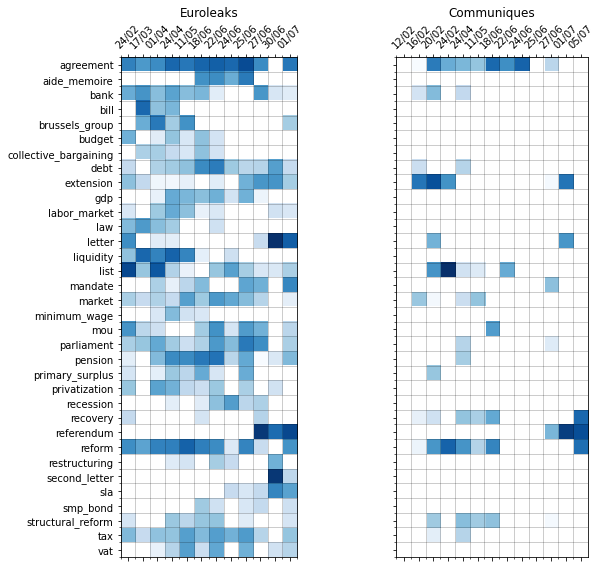

In [41]:
keywords = highlight_differences

fig, axes = plt.subplots(1,2,figsize=(10,8),sharey=True)

# leaks
axes[0].matshow(np.log(leaks_matshow), cmap='Blues')
axes[0].set_xticks(np.arange(len(leaks_dates)))
_ = axes[0].set_xticklabels(leaks_dates, rotation=45)
# grids
axes[0].set_xticks(np.arange(-.5, len(leaks_dates), 1), minor=True)
axes[0].set_yticks(np.arange(len(keywords)))
axes[0].set_yticks(np.arange(-.53, len(keywords), 1), minor=True)
axes[0].grid(which='minor', color='black', linestyle='-', linewidth=.5, alpha=.4)

# communiques
axes[1].matshow(np.log(comm_matshow), cmap='Blues')
axes[1].set_xticks(range(len(communique_dates)))
_ = axes[1].set_xticklabels(communique_dates, rotation=45)
# grids
axes[1].set_xticks(np.arange(-.53, len(leaks_dates), 1), minor=True)
axes[1].set_yticks(np.arange(len(keywords)))
axes[1].set_yticks(np.arange(-.53, len(keywords), 1), minor=True)
axes[1].grid(which='minor', color='black', linestyle='-', linewidth=.5, alpha=.4)

# shared y axis
axes[0].set_yticks(range(len(keywords)))
_ = axes[0].set_yticklabels(keywords)
#axes[1].set_yticks(range(len(keywords)))
#_ = axes[1].set_yticklabels(keywords)

axes[0].set_title('Euroleaks')
axes[1].set_title('Communiques')



fig.tight_layout()

fig.savefig('../figures/term_heatmap.png')

**TODO** investigate terms with text search and read into them:
- bank
- bill
- list

Note that I have taken the log of the matrix so that high scores don't dominate the color spectrum.

# Auxiliary text search

In [33]:
# leaks

def search_term(term):
    for i,row in leaks.iterrows():
        if term in row.speech.lower():
            date = pd.to_datetime(row.date).strftime('%d/%m')
            print(f'{row.speaker} ({date}):')
            print(row.speech)
            print()
            
#search_term('restructuring')

In [34]:
# communiques

def search_term(term):
    for i,row in communiques.iterrows():
        if term in row.story.lower():
            print(f'{row.title} ({row.date}):')
            print(row.story)
            print()
            
#search_term('capital control')